# segmentation 

In [12]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 사진 불러오기

In [30]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' 
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/bg_img/bg_cat.jpeg' 
imgs = os.listdir(img_path)
# bg_imgs_list = os.listdir(bg_path)
# os.listdir(bg_path)
bg_imgs = cv2.imread(bg_path)
# for i in range(0,len(imgs)):
#     image_file = os.path.join(img_path,imgs[i])
#     img_orig[i] = cv2.imread(image_file)
# imggg = cv2.imread(img_path) 
print (imgs)

['노홍철.jpeg', 'unnamed.jpg', 'cat.jpeg', '아저씨.jpg']


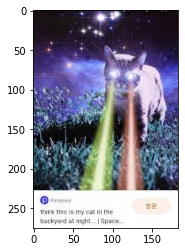

In [3]:
# print(bg_imgs)
plt.imshow(bg_imgs)
plt.show()

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj26/aiffel/human_segmentation/models
model loaded successfully!


In [8]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(314, 628, 3) (256, 513, 3) 15


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

(314, 628, 3)


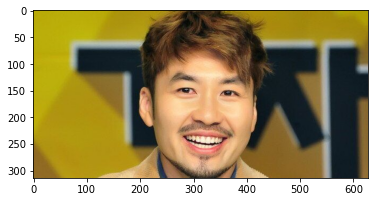

(314, 628, 3) (256, 513, 3) 15


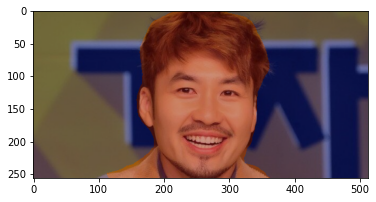

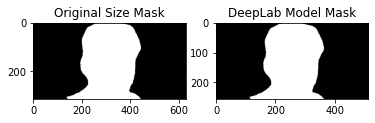

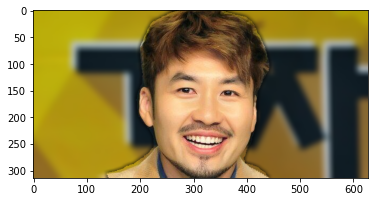

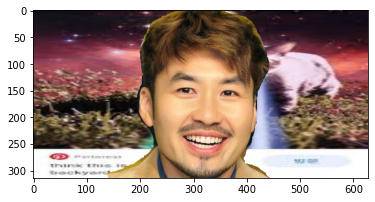

(279, 420, 3)


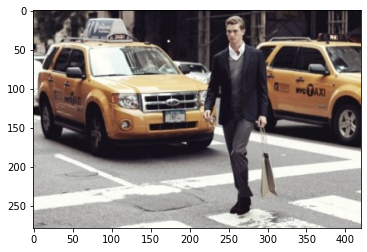

(279, 420, 3) (340, 513, 3) 15


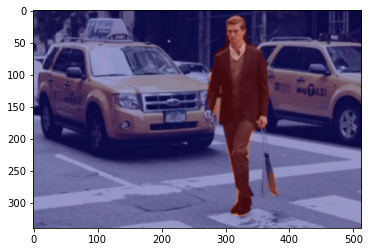

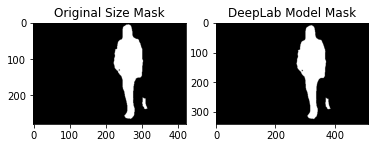

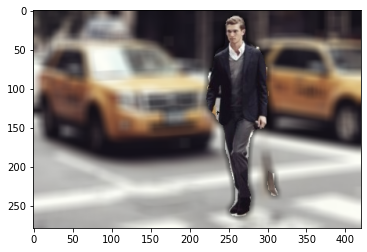

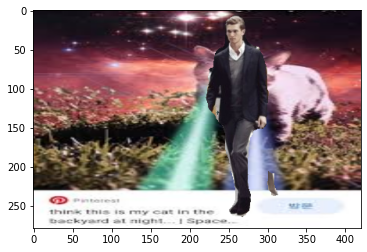

(164, 307, 3)


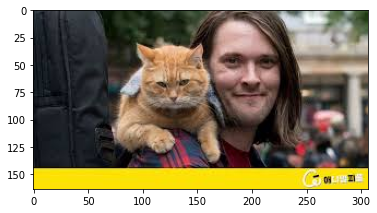

(164, 307, 3) (274, 513, 3) 15


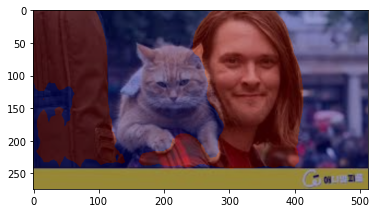

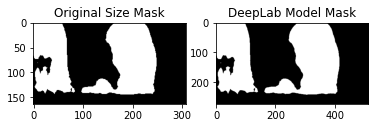

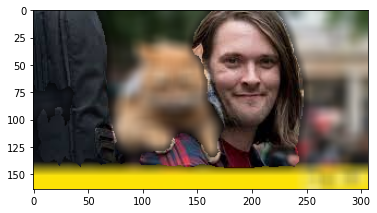

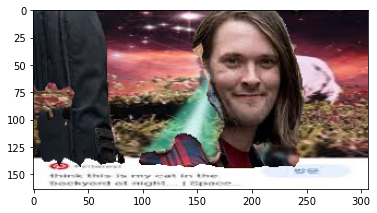

(288, 512, 3)


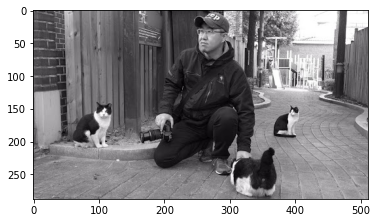

(288, 512, 3) (288, 513, 3) 15


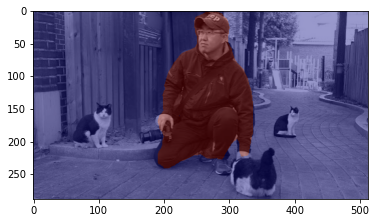

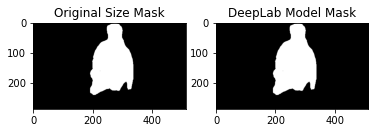

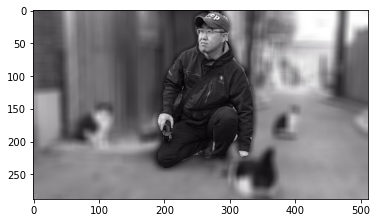

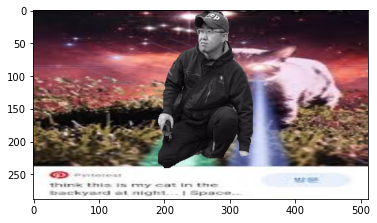

In [42]:
im = []
imono = []
for i in range(len(imgs)):
    image_file = os.path.join(img_path,imgs[i])
    imono.append(image_file)
    img_orig = cv2.imread(image_file)
    im.append(img_orig)
    print(img_orig.shape)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    bg_imgs_rs = cv2.resize(bg_imgs,img_orig.shape[:2][::-1])
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    img_bg_blur = cv2.blur(img_bg, (13,13))

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    img_concat2 = np.where(img_mask_color==255, img_orig, bg_imgs_rs)
    plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
    plt.show()


### 작업 함수화
사진을 입력하고, 인식하고 싶은 번호를 입력하면 인식을 하겠끔하고싶다.


In [7]:
class Segmen:
    def __init__(self,image,detection = 15):
        self.image = image
        img_resized, seg_map = MODEL.run(image)            
        seg_map = np.where(seg_map == detection, detection, 0) # 예측 중 사람만 추출
        img_mask = seg_map * (255/seg_map.max()) # 255 normalization
        img_mask = img_mask.astype(np.uint8)
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        img_mask_up = cv2.resize(img_mask, self.image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
        self.img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    
    def blur(self):
        img_bg_mask = cv2.bitwise_not(self.img_mask_color)
        img_bg = cv2.bitwise_and(self.image, img_bg_mask)
        img_bg_blur = cv2.blur(img_bg, (13,13))
        img_concat = np.where(self.img_mask_color==255, self.image, img_bg_blur)
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()
    
    def cromark(self,image):        
        bg_imgs_rs = cv2.resize(image,self.image.shape[:2][::-1])
        img_concat = np.where(self.img_mask_color==255, self.image, bg_imgs_rs)
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()

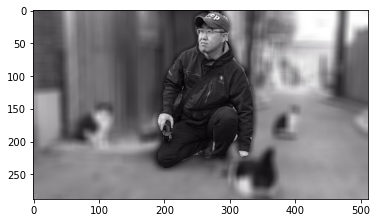

In [32]:
Segmen(im[3]).blur()

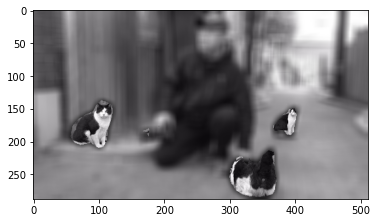

In [33]:
Segmen(im[3],detection = 8).blur()

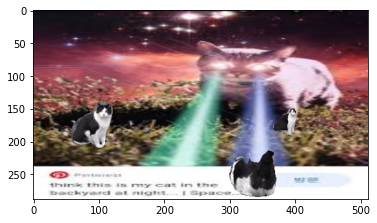

In [34]:
Segmen(im[3],detection = 8).cromark(bg_imgs)

# 모델의 문제 인식
아래의 사진에 가방을 사람으로 인식하고 있다. 

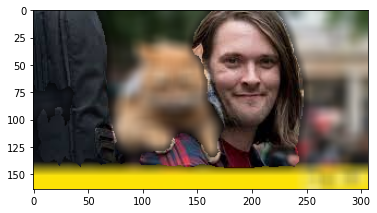

In [62]:
Segmen(im[2]).blur()

# 해결방안
단일 이미지의 깊이를 알 수 있는 struct2depth을 사용하고자 하였다.
모델이 다양하고 오류인지 모르지만 tensorflow의 github에서의 모델의 주소가 찾을 수 없다는 오류가 있어 다른 파생 모델을 찾았다.

## mono2depth 
원래 모델은 영상을 처리하는 거지만 이것은 하나의 이미지를 변환하는데 더 집중을 한것같다. 실험용으로 좋아보여 선택하였다.

필요한 것 import

In [17]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from mono.utils import download_model_if_doesnt_exist

### 모델 불러오기

In [25]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decodeport networks
from mono.utilsr.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

In [41]:
imono

'/home/aiffel-dj26/aiffel/human_segmentation/images/아저씨.jpg'

In [35]:
# image_path = "assets/test_image.jpg"

input_image = pil.open(imono).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

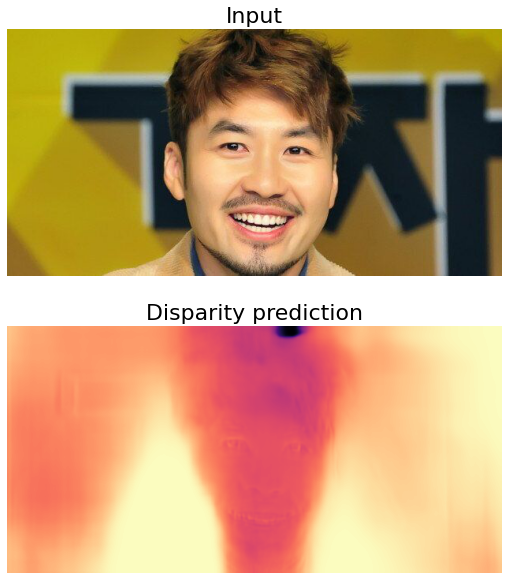

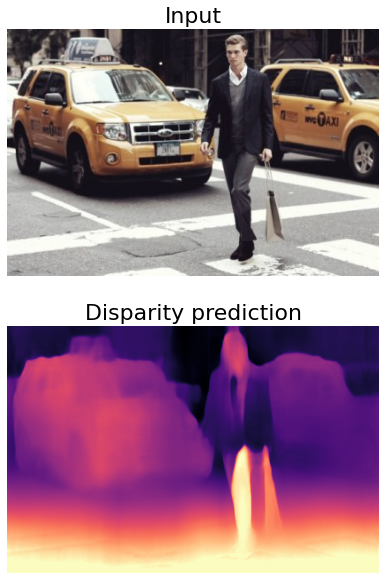

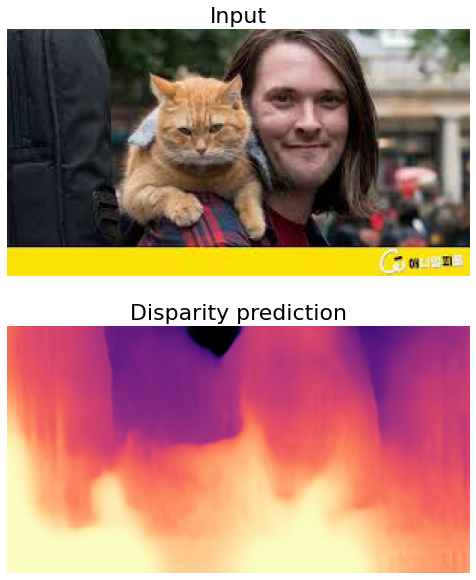

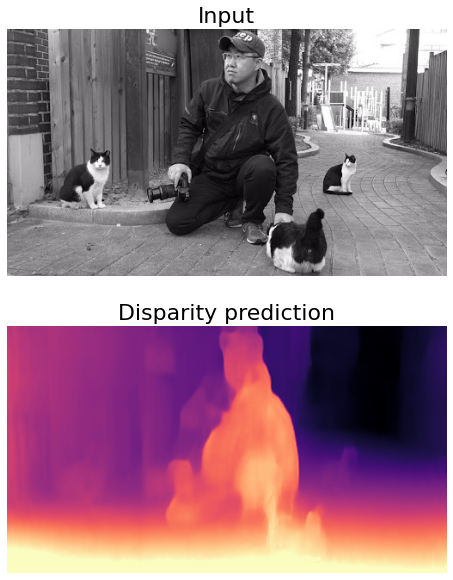

In [43]:
for i in imono:
    input_image = pil.open(i).convert('RGB')
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off');

In [36]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

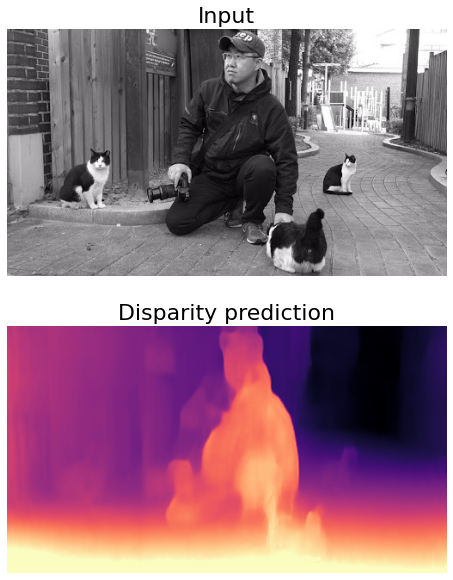

In [37]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

## 모델 시험중 아쉬운점
- 인식 못하는 데이터의 부족  
현재 상황에서 다른것을 사람으로 구별하거나 하는 데이터가 밥의 사진 뿐인데 저사진이 mono2depth의 성능을 발휘할 길거리 사진이거나 화질이 괜찮은 사진이 아니었다.  
그래서 추가적으로 마지막인 사진기를 들고 있는 아저씨사진과 고양이3마리 있는 사진을 구했는데, 심도를 어느정도 구현하는 것 같았다.  
하지만 이건 segmentation의 오류나 성능이 부족하게 나오지는 않았다.  



# 문제 해결 고찰
아직 mono2depth의 모델이 완전한 모델이 아니고 개선해야될 모델이긴 하나 저런 모델이 완성이 된다면,  
사진의 깊이 데이터로 추가적인 segmentation(구별)모델이 아웃포커싱 같은 것은 더 잘 해낼 수 있을 것이다.. 

# 변화한 점
새로운 모델의 검색 및 구현을 해보았다.
# 아쉬운 점
그 새로운 모델을 개선하거나 finetuning을 시도하지 않았다.